# Finding muscle synergies

This tutorial demonstrates how to find muscle synergies using nonnegative matrix factorization.

## Imports and loading the data

We begin by setting up everything: we import the needed libraries and load the data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import functools
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas
import scipy.signal as signal

from muscle_synergies import (
    load_vicon_file,
    plot_signal,
    plot_fft,
    synergy_heatmap,
    linear_envelope,
    time_normalize,
    rms,
    find_synergies,
    )

In [3]:
cwd = Path().resolve()
data_dir = cwd / '..' / '..' / '..' / 'sample_data'
abridged_dataset = data_dir / 'abridged_data.csv' # useful for testing
full_dataset = data_dir / 'dynamic_trial.csv'
dataset = full_dataset.resolve()
dataset

PosixPath('/home/elvis/Organização/Projetos/Biomecânica/emg-code/muscle_synergies/sample_data/dynamic_trial.csv')

In [4]:
vicon_data = load_vicon_file(dataset)
emg_dev = vicon_data.emg
emg_df = emg_dev.df
time_seq = emg_dev.time_seq()
emg_df.index = time_seq
del vicon_data
emg_df.shape

(124460, 8)

## Plotting the signal

### Time-domain: plotting the raw EMG signal

We first visualize the raw signal.
As usual, the EMG signal is 0-centered and biphasic.

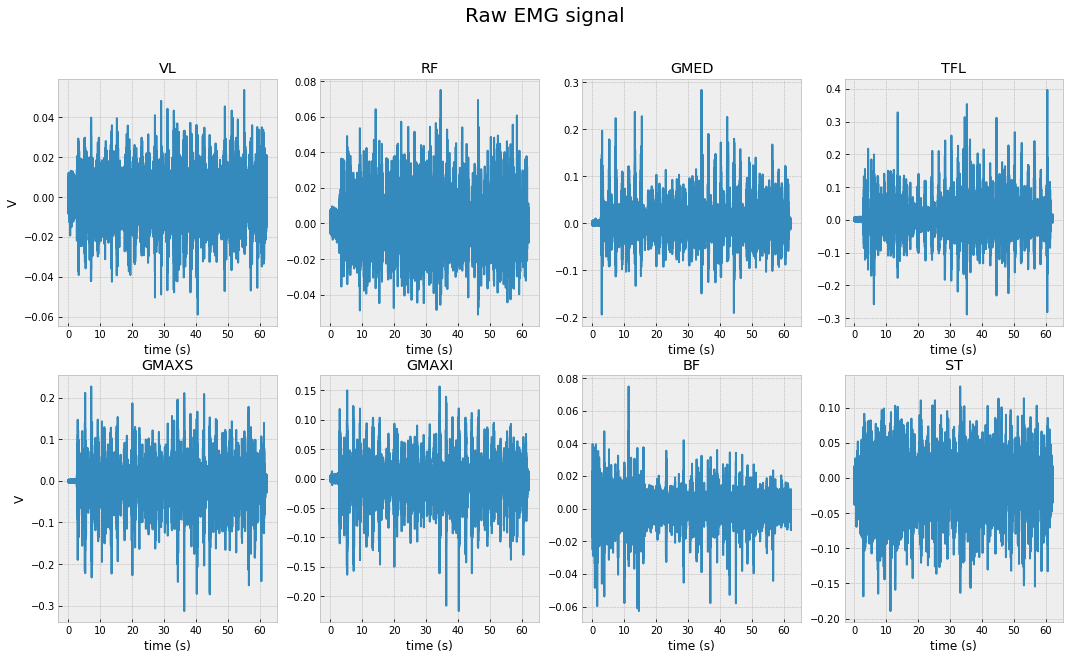

In [5]:
plot_signal(emg_df, title='Raw EMG signal', plot_dims=(2, 4))

### Frequency-domain: plotting the FFT

We are interested in seeing the frequency-domain version of the EMG signal mostly to look for abnormalities.
The EMG signal usually includes only frequencies of up to several hundred Hz.

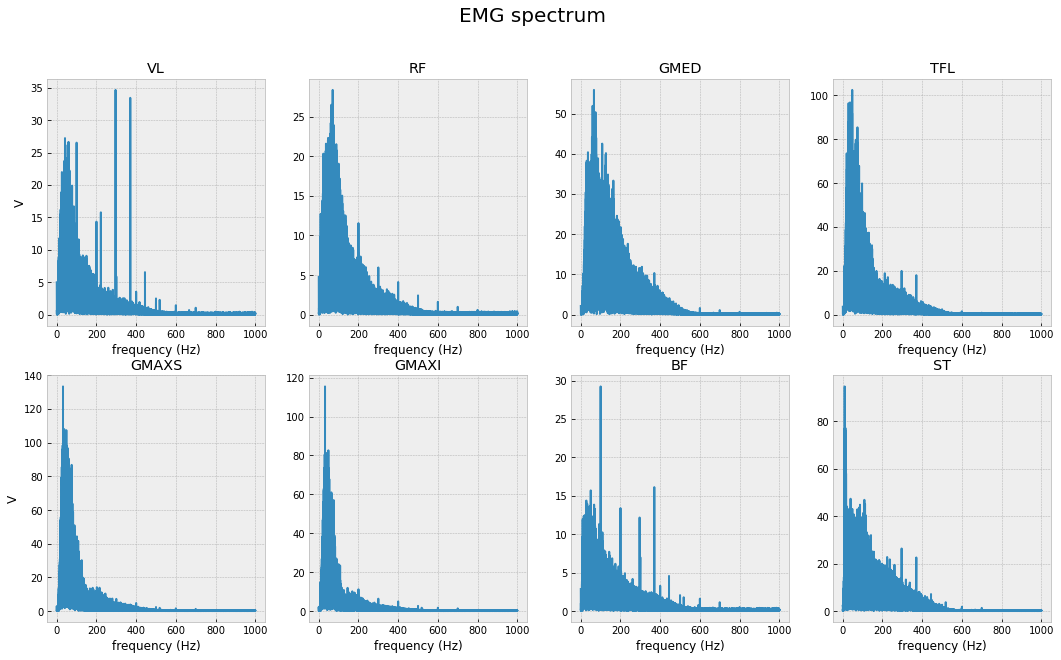

In [6]:
plot_fft(emg_df,
         emg_dev.sampling_frequency,
         xlabel='frequency (Hz)',
         title="EMG spectrum",
         plot_dims=(2, 4))

## Zero-centering the signal

Though the EMG signal is expected to be 0-centered, in practice there might be a residual bias.
So we begin processing the data by subtracting the mean of the signal from each of its channels:

In [7]:
emg_df -= emg_df.mean()

## Finding the envelope of the signal

A common step in EMG analysis is identifying the
[envelope](https://en.wikipedia.org/wiki/Envelope_(waves))
of the signal, which gives us a measure of its intensity at each time.
The 2 common methods for doing this are the linear envelope and RMS.
We'll do both.

### Linear envelope

The linear envelope is found by full-wave rectifying (i.e., `np.abs`) then smoothing (low-pass filtering) the signal. 

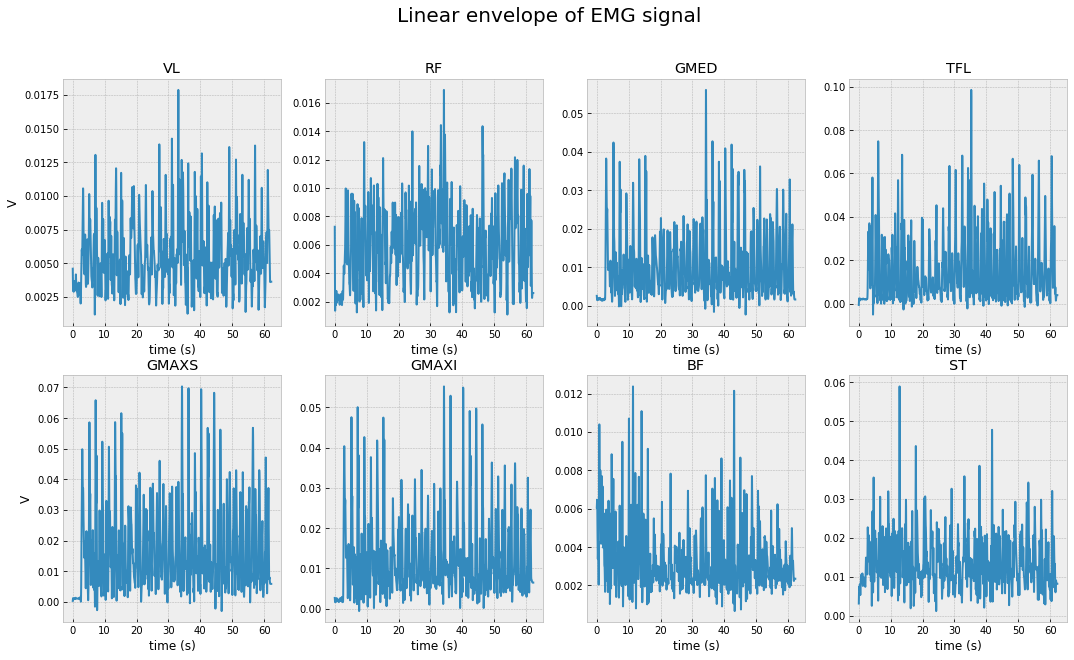

In [8]:
linear_envelope_df = linear_envelope(
    emg_df, 
    critical_freqs=4, # in Hz in this case
    sampling_frequency=emg_dev.sampling_frequency,
    order=13, 
    zero_lag=True,
    zero_center_=False)

plot_signal(linear_envelope_df,
            title='Linear envelope of EMG signal',
            plot_dims=(2, 4))

### RMS

Now we find the RMS of the signal.
Notice that we are not applying the RMS to the linear envelope. 
The RMS is an alternative to the linear envelope and thus their inputs are the same (the 0-centered signal).

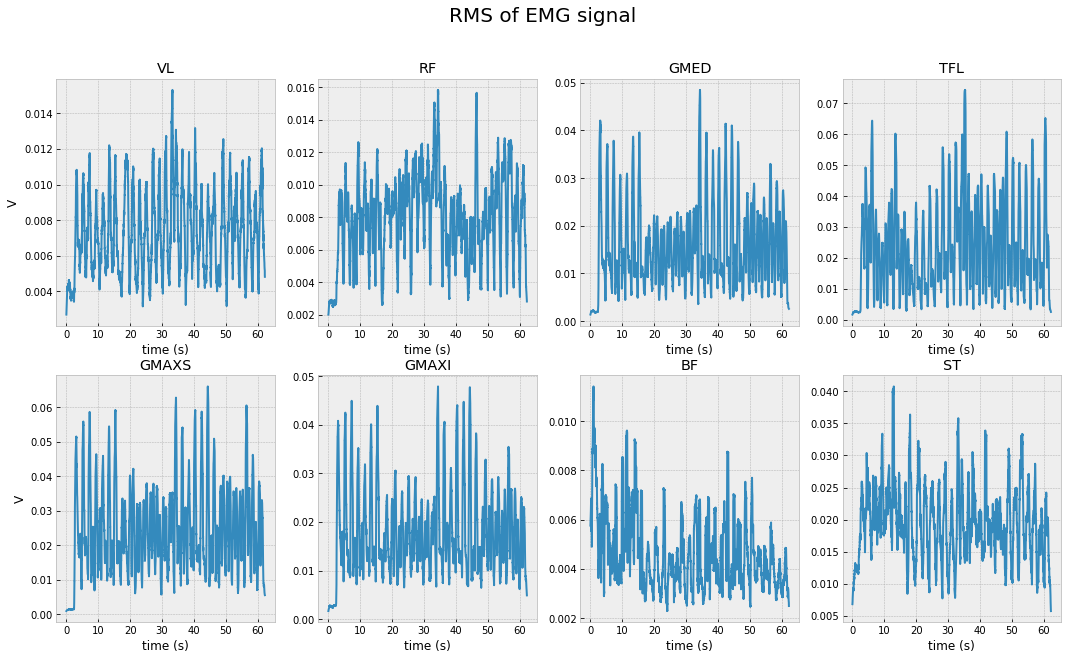

In [9]:
rms_df = rms(
    emg_df,
    window_size=0.5, # in this case, in seconds
    sampling_frequency=emg_dev.sampling_frequency)

plot_signal(rms_df, 
            title='RMS of EMG signal',
            plot_dims=(2, 4))

We will use the RMS to continue the analysis.

In [10]:
processed_df = rms_df

## Normalizing the signal

We now normalize the envelope signal in two ways: 



### Time normalization

The signal is reduced to a smaller number of measurements.
Its original shape...

In [11]:
processed_df.shape

(124460, 8)

...is reduced:

In [12]:
processed_df = time_normalize(
    processed_df,
    reduce_to=200)

processed_df.shape

(200, 8)

### Amplitude normalization

The signal is amplitude normalized by dividing all measurements for each of its channels by the maximum value for that channel.

In [13]:
processed_df /= processed_df.max()

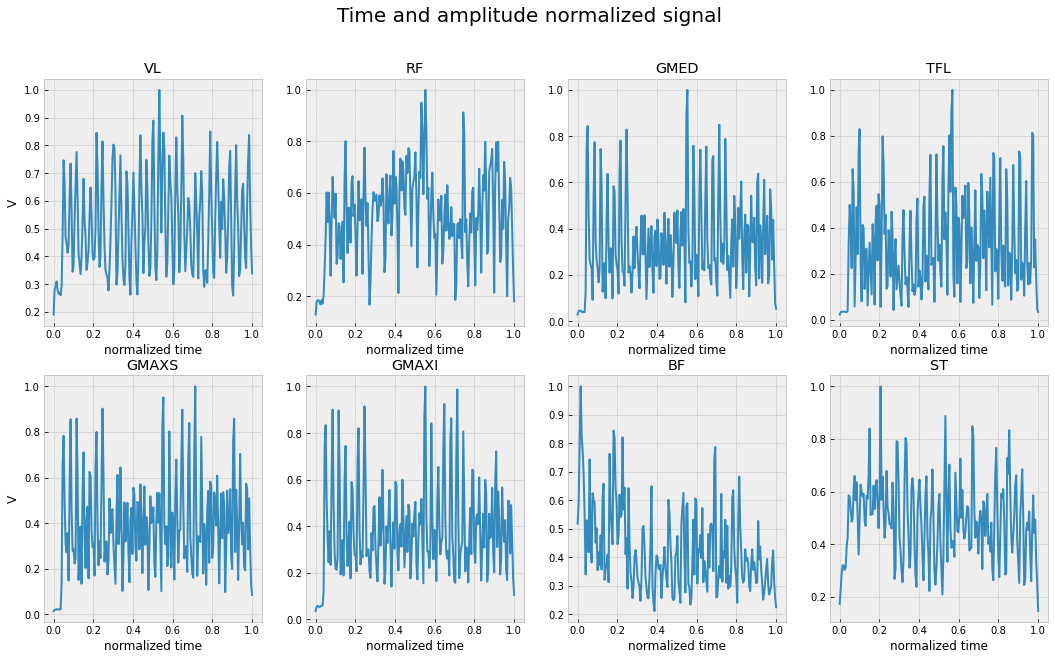

In [14]:
plot_signal(processed_df,
            title='Time and amplitude normalized signal', 
            xlabel='normalized time',
            plot_dims=(2, 4))

## Finding the synergies

We finally try to determine the muscle synergies.
This is done by nonnegative matrix factorization and we can look for different number of synergy components.
We'd generally be interested in finding a small number of components that explain a lot of the variance in the data according to the variance accounted for (VAF) metric.

In [15]:
res = find_synergies(
    processed_df,
    n_components=2,
    max_components=3,
    max_iter=50_000)

/home/elvis/miniconda3/envs/sci3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)
/home/elvis/miniconda3/envs/sci3/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:315: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  "'nndsvda' in 1.1 (renaming of 0.26)."), FutureWarning)


Each row of the `DataFrame` below contains VAFs for different number of synergy components:

In [16]:
res.vaf_values

,All signals,VL,RF,GMED,TFL,GMAXS,GMAXI,BF,ST
2,0.956665,0.965632,0.957076,0.977643,0.867980,0.986059,0.973433,0.930699,0.971668
3,0.975424,0.977011,0.960726,0.984829,0.991887,0.991613,0.992499,0.949407,0.971226


Finally, let's visualize the synergy components found for 3 synergies:

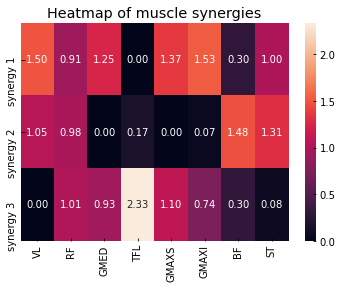

In [17]:
synergy_heatmap(res.components[3])